In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

# Camera / Dataset

In [2]:
batch_size = 1024

o, d, target_px_values = get_rays("pollen", mode="train")
dataloader = DataLoader(
    torch.cat(
        (
            torch.from_numpy(o).reshape(-1, 3).type(torch.float),
            torch.from_numpy(d).reshape(-1, 3).type(torch.float),
            torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float),
        ),
        dim=1,
    ),
    batch_size=batch_size,
    shuffle=True,
)


dataloader_warmup = DataLoader(
    torch.cat(
        (
            torch.from_numpy(o)
            .reshape(90, 400, 400, 3)[:, 100:300, 100:300, :]
            .reshape(-1, 3)
            .type(torch.float),
            torch.from_numpy(d)
            .reshape(90, 400, 400, 3)[:, 100:300, 100:300, :]
            .reshape(-1, 3)
            .type(torch.float),
            torch.from_numpy(target_px_values)
            .reshape(90, 400, 400, 3)[:, 100:300, 100:300, :]
            .reshape(-1, 3)
            .type(torch.float),
        ),
        dim=1,
    ),
    batch_size=batch_size,
    shuffle=True,
)


test_o, test_d, test_target_px_values = get_rays("pollen", mode="test")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.830042..18.020592].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9580673185557737..0.5638636636548033].


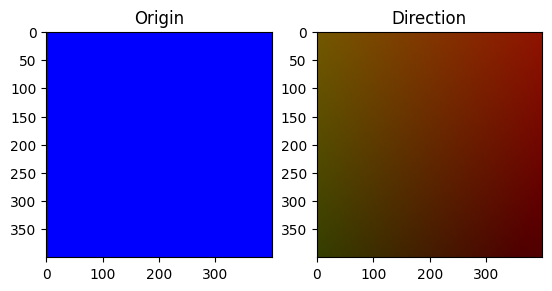

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.80083..16.029366].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.884058062325111..0.7073384940809148].


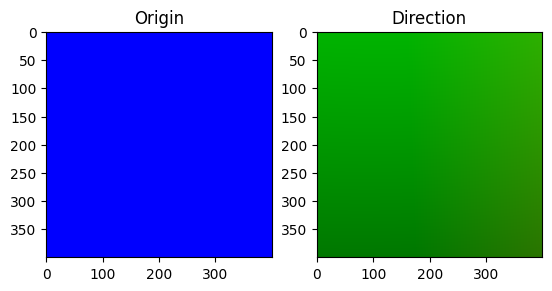

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.56995..14.038141].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8023503281349949..0.5008691053103249].


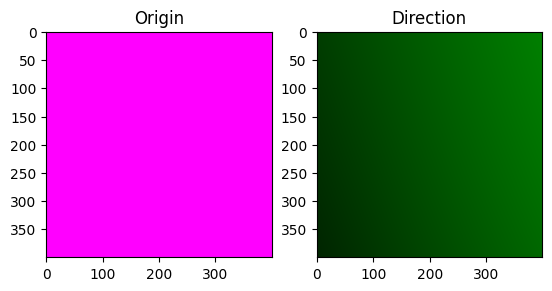

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [9.585088..12.629168].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7800521594737029..-0.3004480633836681].


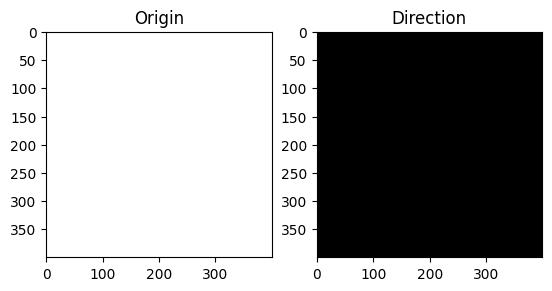

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.608379..16.803591].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9289932234505605..0.3369279968262255].


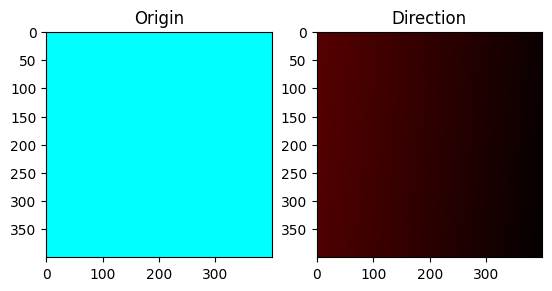

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-17.742478..8.064464].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5360731365591742..0.9626719001876047].


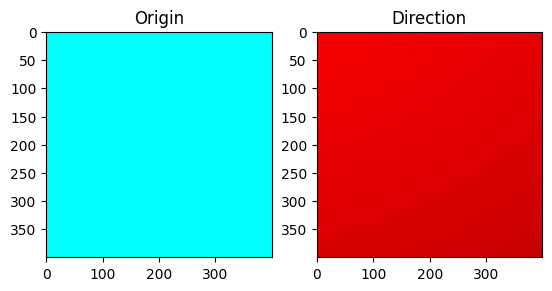

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14.936148..6.073238].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44281713892884683..0.8598209501286429].


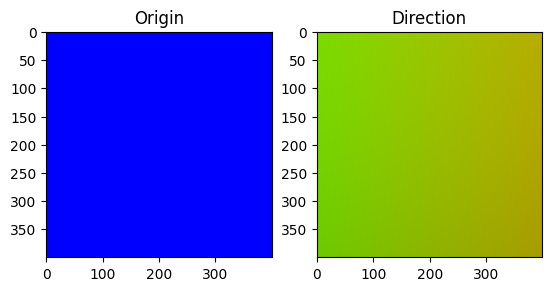

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-17.382618..8.81361].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5779901710957341..0.9471445407803364].


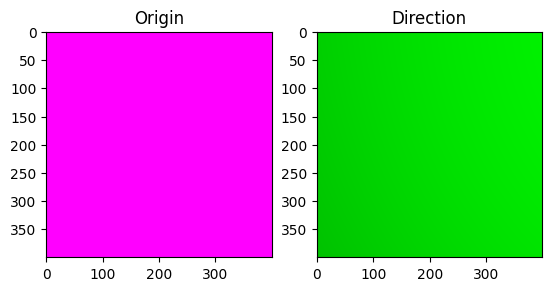

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.62511..19.792316].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999999857876174..0.11717807443669492].


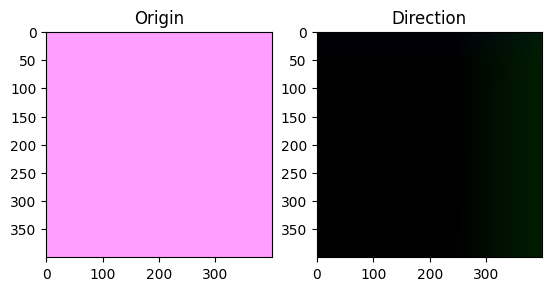

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.099561..18.292419].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.967263494744811..0.14403353653543058].


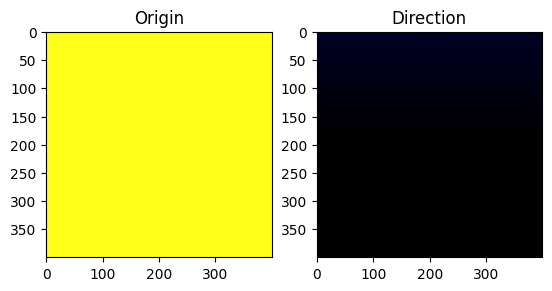

In [3]:
# plot the first 10 rays
for i in range(10):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(test_o[i].reshape(400, 400, 3))
    plt.title("Origin")
    plt.subplot(1, 2, 2)
    plt.imshow(test_d[i].reshape(400, 400, 3))
    plt.title("Direction")
    plt.show()

In [4]:
import torch
import math


def psnr(img1, img2):
    """Calculates PSNR between two images."""
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float("inf")
    max_pixel = 1.0  # Assuming pixel values are in [0, 1]
    psnr_val = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr_val

# Training

100%|██████████| 3516/3516 [00:41<00:00, 85.24it/s]


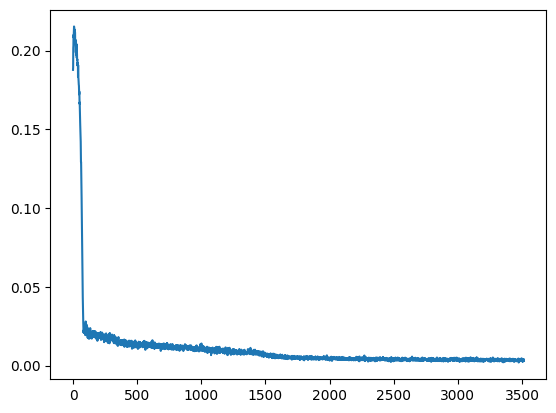

 84%|████████▍ | 11829/14063 [02:20<00:26, 84.92it/s]

: 

In [9]:
device = "cuda"

tn = 18.712256
tf = 21.112256
nb_epochs = 10
lr = 1e-4
gamma = 0.1
nb_bins = 60

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[5, 10], gamma=gamma
)

training_loss = training(
    model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device
)
plt.plot(training_loss)
plt.show()
training_loss = training(
    model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device
)
plt.plot(training_loss)
plt.show()

In [ ]:
torch.save(model, "model_nerf")